# Decentralized Consensus With Gradient Descent

## Background and Problem


Assume neighbor_allreduce and graph has already been discussed.

## Gradient Descent part --- Synthetic dataset + Logistic regression?


1. Adapt-With-Combine:

\begin{equation}
    x_i = A x_i - \alpha \nabla F(x_i)
\end{equation}


2. Adapt-Then-Combine:

\begin{equation}
    x_i = A (x_i - \alpha \nabla F(x_i))
\end{equation}


Discuss the difference between the implementation and overlap of time between the computation and communication.


Three key functions to introduce:

- `neighbor_allreduce` -- already discussed
- `neighbor_allreduce_nonblocking`
- `wait`


Have a brief talk performance difference.


One example code based on manual gradient computation and another on torch auto-gradient computation.


Timeline within one worker (blocking):
```
---communication------|
                      |------computation------
```

Nonblocking case:

```
---communication------|
      ------computation------
```

Use  %timeit to show the difference

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3]

In [3]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 2 among 4 processes
[stdout:1] Hello, I am 3 among 4 processes
[stdout:2] Hello, I am 0 among 4 processes
[stdout:3] Hello, I am 1 among 4 processes


In [4]:
dview = rc[:] # A DirectView of all engines
dview.block=True

In the following code block, we write functions needed to build and train a logistic regression model. These functions include the sigmoid function, the l2-regularized version of logistic regression objective function, and the gradient of that objective function.

The logistic regression model works as follows. We have a set of data $(x_1, y_1), ..., (x_M, y_M)$ where $x_i \in \mathbb{R}^{dim}$ and $y_i \in \{0, 1\}$ for $i=1,...,m$. $dim$ is the dimension of the x vector. Under logistic regression, we define the probability of the random variable $y$ being 1 as 
$$P(y=1|x,w) = \sigma (w^Tx):= \frac{1}{1 + exp(-w^Tx)}$$
and the probability of the random variable $y$ being 0 as
$$P(y=0|x,w) = 1 - \sigma (w^Tx) = 1 - \frac{1}{1 + exp(-w^Tx)} = \frac{exp(-w^Tx)}{1+exp(-w^Tx)}$$
where we also denote $\sigma (w^Tx)$ as the sigmoid function. 
We can combine this into one equation using
$$P(y|x,w) = (\sigma(w^Tx))^y(1 - \sigma(w^Tx))^{(1-y)}$$

Under maximum likelihood optimization, we can derive an optimization problem as follows. 
$$\max_w f(w) := P(y|x,w) = (\sigma(w^Tx))^y(1 - \sigma(w^Tx))^{(1-y)}$$
$$\max_w f(w) := \prod_{i=1}^{M} P(y^i|x^i,w) = \prod_{i=1}^{M} (\sigma(w^Tx^i))^{y^i}(1 - \sigma(w^Tx^i))^{(1-y^i)}$$
We can maximize the log likelihood as log is monotonically increasing.
$$\max_w f(w) := \log(\prod_{i=1}^{M} P(y^i|x^i,w)) = \sum_{i=1}^{M}y^i \log(\sigma(w^Tx^i)) + (1 - y^i)\log(1 - \sigma(w^Tx^i)) $$
We can then reformulate as a minimization problem.
$$\min_w f(w) := - \frac{1}{M}\sum_{i=1}^{M}y^i \log(\sigma(w^Tx^i)) + (1 - y^i)\log(1 - \sigma(w^Tx^i))$$

and incorporating L2-regularization leads us a new objective function
$$\min_w g(w) := \frac{1}{M} \sum_{i=1}^{M}-y^i \log(\sigma(w^Tx^i)) - (1 - y^i)\log(1 - \sigma(w^Tx^i)) + \frac{\lambda}{2}||w||^2_2$$

In our case where we have N workers, this objective function can be reformulated as 

$$\min_w J(w) := \sum_{i=1}^{N} g_i(w)$$

We also calculate the derivative of the sigmoid function.
$$\frac{\partial (\sigma (w^Tx))}{\partial w}  =  \frac{\partial((1+exp(-w^Tx))^{-1})}{\partial w} = \frac{exp(-w^Tx) (-x)}{-(1+exp(-w^Tx))^{2}} = \frac{x}{1+exp(-w^Tx)}\frac{exp(-w^Tx)}{1+exp(-w^Tx)}$$
$$=\frac{x}{1+exp(-w^Tx)}\left(1 - \frac{1}{1+exp(-w^Tx)}\right) = (x) \sigma(w^Tx)(1 - \sigma(w^Tx))$$

Using the derivative of the sigmoid function, we can derive the gradient of $g(w)$.

$$\frac{\partial g(w)}{\partial w} = \frac{1}{M} \sum_{i=1}^{M} -(y_i - \sigma(w^Tx^i)) x^i  + \lambda w$$

In [5]:
%%px

# Implement functions for logistic regression.

def sigmoid(x):
    '''Return the output of the sigmoid function.
    Args:
     - x (torch tensor): Input that we want to apply the sigmoid function on.
    Return:
    - Return a torch tensor of the output 
        
    '''
    return 1.0 / (1.0 + torch.exp(-x))

def obj(w, X, y, reg):
    '''Output of the objective function of logistic regression.
    Args:
     - w (torch tensor): Parameter.
     - X (torch tensor): Data.
     - y (torch tensor): Labels.
     - reg (float): Regularization parameter.
    Return:
     - Returns a float of the value of the objective function.
    '''
    M, _ = X.shape
    
    return -1/M * torch.sum(y[:, None] * X @ w - torch.log(1 + torch.exp(X @ w))) + reg/2 * torch.norm(w, p=2)
#     return 1/M * torch.sum(-(y[:, None] * torch.log(sigmoid(X @ w))) \
#                            - ((1 - y[:, None]) * torch.log(1 - sigmoid(X @ w)))) \
#                            + reg/2 * torch.norm(w, p=2)

def grad(w, X, y, reg):
    '''Output of the gradient for the logistic regression.
    Args:
     - w (torch tensor): Parameter.
     - X_batch (torch tensor): Batch of data gradient is calculated on.
     - y_batch (torch tensor): Labels.
     - reg (float): Regularization parameter.
    Return:
     - Returns a torch tensor that is the gradient for the data and parameters provided.
    '''
    M, _ = X.shape
    return -1/M * (X.T @ y[:, None] - (X.T @ (1 - sigmoid(-X @ w)))) + reg * w
#     return -1/M * X.T @ (y[:, None] - sigmoid(X @ w)) + reg * w

In the following cell, we generate synthetic data for us to train our logistic regression model on. Note that each worker will have data drawn from its own distribution.  

In [6]:
%%px 

# Generate the data for each worker. Each worker will have data from a different distribution.

M = 8000     # N (int) := Number of data points.
dim = 10     # dim (int) := Dimension of a data point.
reg = 1e-4     # reg (float) := Regularization parameter.
np.random.seed(0)     # Set seed.
torch.manual_seed(0)     # Set seed.

# Generate the data and labels for 2 classes.
X, y = make_classification(n_samples=M, n_features=dim,random_state=bf.rank()) 
X = normalize(X, axis=1, norm='l2')     # Normalize the data set.

X_tensor = torch.Tensor(X).to(torch.float32) # Convert the data to tensors.
y_tensor = torch.Tensor(y).to(torch.float32)

In the below section, we perform a distributed version of full gradient descent which essentially simplies to centralized full gradient descent. This is to find the optimal solution for the logistic regression problem on the synthetic data to compare the results our other algorithm implementations.

In [7]:
%%px

# Create a distributed gradient descent function that is equivalent to centralized gradient descent.
def distributed_grad_descent(X, y, reg=1e-4, maxite=1000, step_size=1):
    M, dim = X.shape
    w_opt = 0.001 * torch.randn((dim, 1))
    for i in range(maxite):
        # Calculate local gradient.
        grad_iter = grad(w_opt, X, y, reg)
        # Use local gradient to calculate global gradient.
        gradient = bf.allreduce(grad_iter)
        
        # Distributed gradient descent.
        w_opt = w_opt - step_size * gradient
    print(f"[DG] Rank {bf.rank()}: Global Gradient Norm: {torch.norm(gradient, p=2)}")
    return w_opt

In [8]:
%%px

# Find the optimal solution.
w_opt = distributed_grad_descent(X_tensor, y_tensor)

print(w_opt)

[stdout:0] 
[DG] Rank 2: Global Gradient Norm: 8.380438885069452e-07
tensor([[-0.0446],
        [ 1.9808],
        [-0.4406],
        [ 0.7508],
        [ 0.0566],
        [ 1.9223],
        [-0.3362],
        [ 0.1628],
        [ 0.3968],
        [ 2.8474]])
[stdout:1] 
[DG] Rank 3: Global Gradient Norm: 8.380438885069452e-07
tensor([[-0.0446],
        [ 1.9808],
        [-0.4406],
        [ 0.7508],
        [ 0.0566],
        [ 1.9223],
        [-0.3362],
        [ 0.1628],
        [ 0.3968],
        [ 2.8474]])
[stdout:2] 
[DG] Rank 0: Global Gradient Norm: 8.380438885069452e-07
tensor([[-0.0446],
        [ 1.9808],
        [-0.4406],
        [ 0.7508],
        [ 0.0566],
        [ 1.9223],
        [-0.3362],
        [ 0.1628],
        [ 0.3968],
        [ 2.8474]])
[stdout:3] 
[DG] Rank 1: Global Gradient Norm: 8.380438885069452e-07
tensor([[-0.0446],
        [ 1.9808],
        [-0.4406],
        [ 0.7508],
        [ 0.0566],
        [ 1.9223],
        [-0.3362],
        [ 0.1628],

In the following cell, we generate the same graph from the previous tutorial to use. As we mentioned in the previous section, we then use the set_topology() function to set the virtual topology MPI uses to graph we generated before. The load_toplogy() function then returns the virtual topology MSI is using. Afterwards, we use the GetRecvWeights() function to return the weight of the vertex itself as well as the weights of its neighbors. 

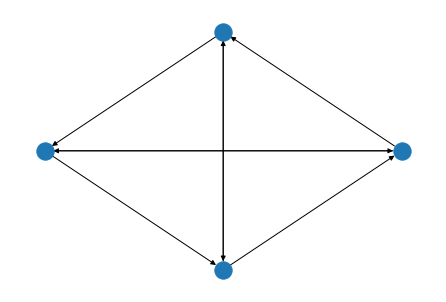

In [9]:
# Generate topology.

# Plot figure
%px G = topology_util.ExponentialTwoGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

In [10]:
%%px

# Set topology as exponential-2 graph.
bf.set_topology(G)
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(topology, bf.rank())

In [11]:
%%px
# Print weights.

if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)

[stdout:2] 
self weights: 0.3333333333333333

neighbor weights:
2 0.3333333333333333
3 0.3333333333333333


We then implement the adapt then combine algorithm from before. This algorithm works as follows. Each vertex does a local gradient update step which is called the "adaptation step". After the local gradient is updated, we perform a "combine" step in which each vertex communicates with it neighbors. This step essentially has a vertex find a weighted average of its own parameters with its neighbors and can be easily achieved through the use of the bf.neighbor_allreduce() as explained in the previous tutorial section.

In [12]:
%%px

# Adapt then combine using blocking communication.

def ATC(X, y, w_opt, w=None, step_size=1.0, reg=1e-4):
    """
    Adapt then combine algorithm using blocking communication. Performs one iteration.
    Inputs:
    - X (torch tensor) := The data to calculate the loss on of size (N, dim).
    - y (torch tensor) := The corresponding labels of the data of size (N, 1).
    - w_opt (torch tensor) := The optimal parameters.
    - w (torch tensor) := The parameter to update over.
    - step_size (float) := The step size parameter.
    - reg (float) := The regularization parameter.
    - batch_size (int) := Size of a batch for the iteration.
    Output:
    - w (torch tensor) := Update iteration.
    - Relative error of all workers.
    """
    M, dim = X.shape
    
    if w is None:
        w = 0.001 * torch.randn((dim, 1))
    
    adapt = w - step_size * grad(w, X, y, reg)
    combine = bf.neighbor_allreduce(adapt, self_weight, neighbor_weights)
    w = combine

    dist = torch.norm(w - w_opt, p=2)/torch.norm(w_opt, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    
    return w, torch.sqrt(averaged_relative_error)

In [13]:
# Run the Adapt-Then-Combine Algorithm

maxite = 1000
relative_error = torch.zeros((maxite, 1))
%px w = None
for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
    
    %px w, relative_error_ite = ATC(X_tensor, y_tensor, w_opt, w=w)
    relative_error[ite] = dview.pull('relative_error_ite', block=True, targets=0)

Progress 0/1000
Progress 100/1000
Progress 200/1000
Progress 300/1000
Progress 400/1000
Progress 500/1000
Progress 600/1000
Progress 700/1000
Progress 800/1000
Progress 900/1000


Below is the plot of the relative error versus iterations.

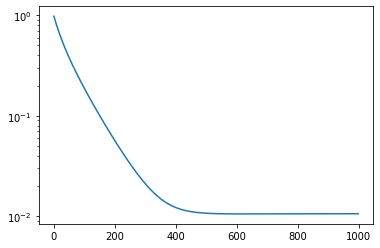

In [14]:
plt.semilogy(relative_error)

Now we implement the Adapt-Then-Combine algorithm. This algorithm has some notable differences from the Adapt-With-Combine algorithm. The adaptation step and the combination step are not done sequentially but rather are done in parallel. This allows us to take advantage of the non-blocking communication available using bluefog. 

Now we will discuss the difference between non-blocking and blocking communication. In the Adapt-Then-Combine algorithm, we first did the adapation step and then followed with the combination step. For this implementation, we used blocking communication by using the neighbor_allreduce() function. As a result, during the combination step, we will need to wait for the communication between all vertices to finish before moving onwards.

For the Adapt-Then-Combine algorithm, we use non-blocking communication. We can think of non-blocking communication in this way. The function call neighbor_allreduce_nonblocking() generates a handle. A handle is similar to a ticket which requests that the vertices to communicate. The communication does not necessarily happen immediately and the code can continue to progress. Thus, while we wait for the communication to finish, the adapation step (the gradient calculation) can be processed. This can give us time savings as we do not have to wait for communication to finish before performing the adaptation step. After the gradient calculation, we use the bf.wait() command to wait for the communication to finish in order to complete the update. The bf.wait() command will return the desired output from the communication.

In [15]:
%%px

# Adapt with combine using non-blocking communication.

def AWC(X, y, w_opt, w=None, step_size=1.0, reg=1e-4):
    """
    Adapt with combine algorithm using non-blocking communication. Performs one iteration.
    Inputs:
    - X (torch tensor) := The data to calculate the loss on of size (N, dim).
    - y (torch tensor) := The corresponding labels of the data of size (N, 1).
    - w_opt (torch tensor) := The optimal parameters.
    - w (torch tensor) := The parameter to update over.
    - step_size (float) := The step size parameter.
    - reg (float) := The regularization parameter.
    - batch_size (int) := Size of a batch for the iteration.
    Output:
    - Relative error of all workers.
    """
    M, dim = X.shape
    
    if w is None:
        w = 0.001 * torch.randn((dim, 1))

    
    combine_handle = bf.neighbor_allreduce_nonblocking(w, self_weight, neighbor_weights)
    adapt = step_size * grad(w, X, y, reg)
    combine = bf.wait(combine_handle)
    w = combine - adapt

    dist = torch.norm(w - w_opt, p=2)/torch.norm(w_opt, p=2)
    averaged_relative_error = bf.allreduce(dist**2, average=True)
    
    return w, torch.sqrt(averaged_relative_error)

In [16]:
# Run the Adapt-With-Combine Algorithm

maxite = 1000
relative_error = torch.zeros((maxite, 1))
%px w = None
for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
    
    %px w, relative_error_ite = AWC(X_tensor, y_tensor, w_opt, w=w)
    relative_error[ite] = dview.pull('relative_error_ite', block=True, targets=0)

Progress 0/1000
Progress 100/1000
Progress 200/1000
Progress 300/1000
Progress 400/1000
Progress 500/1000
Progress 600/1000
Progress 700/1000
Progress 800/1000
Progress 900/1000


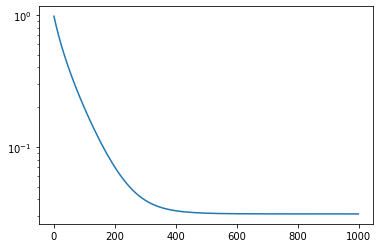

In [17]:
plt.semilogy(relative_error)

Previously, we calculated the gradient manually. Another method instead of calculating the gradient manually, is to use the autograd functionality of pytorch. We can demonstrate this for both Adapt-Then-Combine and Adapt-With-Combine. 

In [18]:
%%px

# Adapt then combine using blocking communication with autograd.

def obj_autograd(w, X, y, reg):
    '''Output of the objective function of logistic regression.
    Args:
     - w (torch tensor): Parameter.
     - X (torch tensor): Data.
     - y (torch tensor): Labels.
     - reg (float): Regularization parameter.
    Return:
     - Returns a float of the value of the objective function.
    '''
    M, _ = X.shape
    loss = 1/M * torch.sum(-(y[:, None] * torch.log(sigmoid(X @ w))) \
                           - ((1 - y[:, None]) * torch.log(1 - sigmoid(X @ w)))) \
                           + reg/2 * torch.norm(w, p=2)
    loss.backward()
    


def ATC_autograd(X, y, w_opt, w=None, step_size=1.0, reg=1e-4):
    """
    Adapt then combine algorithm using blocking communication and autograd. Performs one iteration.
    Inputs:
    - X (torch tensor) := The data to calculate the loss on of size (N, dim).
    - y (torch tensor) := The corresponding labels of the data of size (N, 1).
    - w_opt (torch tensor) := The optimal parameters.
    - w (torch tensor) := The parameter to update over.
    - step_size (float) := The step size parameter.
    - reg (float) := The regularization parameter.
    - batch_size (int) := Size of a batch for the iteration.
    Output:
    - Relative error of all workers.
    """
    M, dim = X.shape
    
    if w is None:
        w = 0.001 * torch.randn((dim, 1))
        w.requires_grad = True
    
    
    obj_autograd(w, X, y, reg)
    
    with torch.no_grad():
        gradient = w.grad.data
        adapt = w.data - step_size * gradient
        combine = bf.neighbor_allreduce(adapt, self_weight, neighbor_weights)
        w.data = combine
        w.grad.data.zero_()

        dist = torch.norm(w - w_opt, p=2)/torch.norm(w_opt, p=2)
        averaged_relative_error = bf.allreduce(dist**2, average=True)
    
    return w, torch.sqrt(averaged_relative_error)

In [19]:
# Run the Adapt-Then-Combine Algorithm with Autograd

maxite = 1000
relative_error = torch.zeros((maxite, 1))
%px w = None
for ite in range(maxite):

    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
    
    %px w, relative_error_ite = ATC_autograd(X_tensor, y_tensor, w_opt, w=w)
    relative_error[ite] = dview.pull('relative_error_ite', block=True, targets=0)

Progress 0/1000
Progress 100/1000
Progress 200/1000
Progress 300/1000
Progress 400/1000
Progress 500/1000
Progress 600/1000
Progress 700/1000
Progress 800/1000
Progress 900/1000


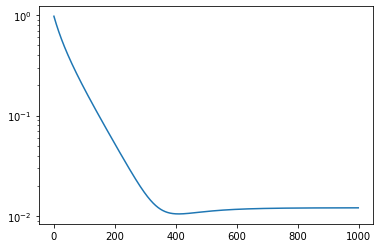

In [20]:
plt.semilogy(relative_error)

In [21]:
%%px

def AWC_autograd(X, y, w_opt, w=None, step_size=1.0, reg=1e-4):
    """
    Adapt with combine algorithm using blocking communication and autograd. Performs one iteration.
    Inputs:
    - X (torch tensor) := The data to calculate the loss on of size (N, dim).
    - y (torch tensor) := The corresponding labels of the data of size (N, 1).
    - w_opt (torch tensor) := The optimal parameters.
    - w (torch tensor) := The parameter to update over.
    - step_size (float) := The step size parameter.
    - reg (float) := The regularization parameter.
    - batch_size (int) := Size of a batch for the iteration.
    Output:
    - Relative error of all workers.
    """
    M, dim = X.shape
    
    if w is None:
        w = 0.001 * torch.randn((dim, 1))
        w.requires_grad = True
    
    with torch.no_grad():
        combine_handle = bf.neighbor_allreduce_nonblocking(w.data, self_weight, neighbor_weights)
    
    obj_autograd(w, X, y, reg)
    
    with torch.no_grad():
        gradient = w.grad.data
        adapt = step_size * gradient
        combine = bf.wait(combine_handle)
        w.data = combine - adapt    
        w.grad.data.zero_()

        dist = torch.norm(w - w_opt, p=2)/torch.norm(w_opt, p=2)
        averaged_relative_error = bf.allreduce(dist**2, average=True)
    
    return w, torch.sqrt(averaged_relative_error)

In [22]:
# Run the Adapt-With-Combine Algorithm with Autograd

maxite = 1000
relative_error = torch.zeros((maxite, 1))
%px w = None
for ite in range(maxite):

    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
    
    %px w, relative_error_ite = AWC_autograd(X_tensor, y_tensor, w_opt, w=w)
    relative_error[ite] = dview.pull('relative_error_ite', block=True, targets=0)

Progress 0/1000
Progress 100/1000
Progress 200/1000
Progress 300/1000
Progress 400/1000
Progress 500/1000
Progress 600/1000
Progress 700/1000
Progress 800/1000
Progress 900/1000


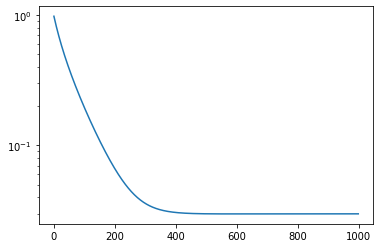

In [23]:
plt.semilogy(relative_error)

## Stochastic Gradient part -- Application : MNIST

Related with reading the dataset and plot the figures and visualized the weights.

Similar but more about the MSE metrics and irreducible error?

More focus on the theoratical part and choose different application.


In [24]:
# Load the MNIST dataset.

from torchvision import datasets


dataset = datasets.MNIST('../data', train=True, download=True)

Since logistic regression is a binary problem we will take a subset of the data that has labels 0 or 1. In addition, because MNIST images are 28 $\times$ 28 images, we will reshape each image to be a vector of size 784. Each image in the MNIST data set is grayscale so an element of a MNIST image ranges from 0 to 255. 

In [25]:
idx = (dataset.targets==0) | (dataset.targets==1)
X = dataset.data[idx].view(dataset.data[idx].shape[0], -1)
y = dataset.targets[idx][:, None]

We will confirm the shape of our new data and label matrix.

In [26]:
print(X.shape)
print(y.shape)

torch.Size([12665, 784])
torch.Size([12665, 1])


We will normalize each image such that each element will range from 0 to 1 instead of 0 to 255.

In [27]:
X = X / 255.

Each individual image or data point is just a vector of size 784.

In [28]:
X[0, :].shape

torch.Size([784])

Below, we plot an example image. 

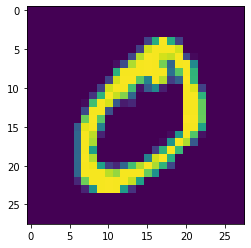

In [29]:
plt.imshow(X[0, :].view(28,28))

In [30]:
# Move the data to the workers.
M, dim = X.shape
num_split = int(M//(len(rc.ids)))
for i in range(len(rc.ids)):
    subset_data = X[i*num_split:(i+1)*num_split]
    subset_targets = y[i*num_split:(i+1)*num_split]
    subset_targets = torch.squeeze(subset_targets)
    subset_targets = subset_targets.type(torch.FloatTensor)
    dview.push({'subset_data': subset_data, 'subset_targets': subset_targets}, targets=i)

Confirm that the data has been moved successfully.

In [31]:
%%px
print(subset_data.shape)
print(subset_targets.shape)

[stdout:0] 
torch.Size([3166, 784])
torch.Size([3166])
[stdout:1] 
torch.Size([3166, 784])
torch.Size([3166])
[stdout:2] 
torch.Size([3166, 784])
torch.Size([3166])
[stdout:3] 
torch.Size([3166, 784])
torch.Size([3166])


Find the optimal result using the distributed gradient descent function developed before. 

In [32]:
%%px

# Find the optimal solution.
w_opt_mnist = distributed_grad_descent(subset_data, subset_targets, maxite=5000)

print(w_opt_mnist)

[stdout:0] 
[DG] Rank 2: Global Gradient Norm: 0.00021534210827667266
tensor([[-1.5850e-03],
        [-1.0289e-03],
        [-1.3843e-04],
        [ 1.6980e-04],
        [ 4.4425e-05],
        [ 6.7525e-04],
        [ 1.7120e-04],
        [ 2.6336e-04],
        [ 2.7714e-04],
        [-5.2486e-04],
        [ 4.7388e-04],
        [-5.6211e-04],
        [ 1.2519e-04],
        [-2.0224e-04],
        [-2.6009e-04],
        [ 1.4127e-04],
        [ 5.8378e-04],
        [ 2.1178e-04],
        [-5.5888e-04],
        [-3.4083e-05],
        [-4.2549e-04],
        [ 6.2877e-04],
        [-3.6614e-04],
        [-7.7559e-04],
        [ 7.5149e-05],
        [ 7.0646e-04],
        [ 5.6004e-04],
        [ 8.4142e-04],
        [ 8.3398e-04],
        [ 4.0008e-04],
        [ 2.8904e-04],
        [-6.1641e-04],
        [ 3.7020e-04],
        [ 2.8317e-04],
        [ 1.1831e-03],
        [-6.4479e-04],
        [ 6.9164e-04],
        [-5.4515e-05],
        [ 4.4263e-04],
        [-1.2401e-03],
        [-

Run the Adapt-Then-Combine Algorithm.

In [33]:
# Run the Adapt-Then-Combine Algorithm

maxite = 1000
relative_error = torch.zeros((maxite, 1))
%px w = None
for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
    
    %px w, relative_error_ite = ATC(subset_data, subset_targets, w_opt_mnist, step_size=1, w=w)
    relative_error[ite] = dview.pull('relative_error_ite', block=True, targets=0)

Progress 0/1000
Progress 100/1000
Progress 200/1000
Progress 300/1000
Progress 400/1000
Progress 500/1000
Progress 600/1000
Progress 700/1000
Progress 800/1000
Progress 900/1000


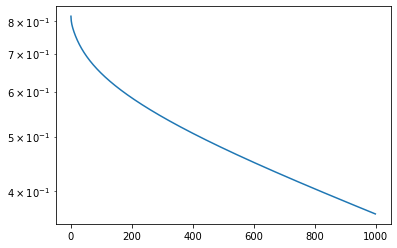

In [34]:
plt.semilogy(relative_error)

In [35]:
# Run the Adapt-With-Combine Algorithm

maxite = 1000
relative_error = torch.zeros((maxite, 1))
%px w = None
for ite in range(maxite):
    
    if ite%100 == 0:
        print('Progress {}/{}'.format(ite, maxite))
    
    %px w, relative_error_ite = AWC(subset_data, subset_targets, w_opt_mnist, step_size=1, w=w)
    relative_error[ite] = dview.pull('relative_error_ite', block=True, targets=0)

Progress 0/1000
Progress 100/1000
Progress 200/1000
Progress 300/1000
Progress 400/1000
Progress 500/1000
Progress 600/1000
Progress 700/1000
Progress 800/1000
Progress 900/1000


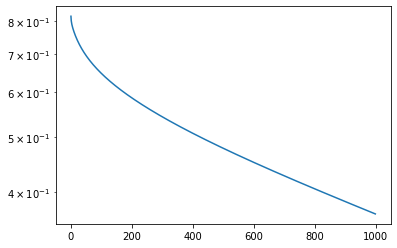

In [36]:
plt.semilogy(relative_error)

For our plots, we used relative error which is the L2-norm of the difference between the current set of parameters and the optimal set of parameters divided by the L2-norm of the optimal set of parameters.